In [11]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import av
from av.video.stream import VideoStream
import numpy as np
import tqdm
from sklearn.model_selection import cross_val_score
import os
import catboost
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_stats_for_file(array_file):
    array_file = np.array(array_file)

    minim_mean = array_file.mean() - array_file.min()
    maxim_mean = array_file.max() - array_file.mean()
    std = array_file.std()

    diff = np.diff(array_file , n = 1)
    min_max_1 = diff.max() - diff.min()
    std_diff_1 = diff.std()

    diff = np.diff(array_file , n = 2)
    min_max_2 = diff.max() - diff.min()
    std_diff_2 = diff.std()

    diff = np.diff(array_file , n = 3)
    min_max_3 = diff.max() - diff.min()
    std_diff_3 = diff.std()

    return [minim_mean , maxim_mean , std, min_max_1 , std_diff_1 , min_max_2 , std_diff_2 ,min_max_3 , std_diff_3]

In [3]:
def print_image(frame):
    r = 1000.0 / frame.shape[1]
    dim = (1000, int(frame.shape[0] * r))
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

    cv2.imshow('frame',resized)
    k = cv2.waitKey(30) & 0xff
    if k == ord('q'):
        return

In [5]:
path = 'trainset/'
files = [video for video in os.listdir(path) if ".avi" in video and "._" not in video]

In [6]:
real_answ = pd.DataFrame.from_csv("train.csv")

In [19]:
all_diff_norm = []
all_diff_x = []
all_diff_y = []
for file in tqdm_notebook(files[3:4]):
    input_container = av.open(path + file)
    input_packets = input_container.demux()
    point_file = file[:-8]+'txt'
    y,x = open(path+point_file, 'r').readline().split(' ')
    x,y = int(x), int(y)
    diff_dist = []
    diff_x = []
    diff_y = []
    num = 0
    for packet in input_packets:
        frames = packet.decode()
        for raw_frame in frames:
            num+=1
            if (num<10):
                continue
            frame = raw_frame.to_rgb().to_nd_array()
            frame =  cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = frame[x - 100 : x + 200 , y - 100 : y + 100]
            if (num % 300) == 0:
                all_diff_norm.append(diff_dist)
                all_diff_x.append(diff_x)
                all_diff_y.append(diff_y)
            if (num % 10) == 0:
                # params for ShiTomasi corner detection
                feature_params = dict( maxCorners = 100,
                                    qualityLevel = 0.3,
                                    minDistance = 7,
                                    blockSize = 7 )

                # Parameters for lucas kanade optical flow
                lk_params = dict( winSize  = (10,10),
                               maxLevel = 2,
                               criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

                # Create some random colors
                color = np.random.randint(0,255,(100,3))
                # Take first frame and find corners in it
                old_frame = frame
                old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
                p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

                # Create a mask image for drawing purposes
                mask = np.zeros_like(old_frame)

            else:
                try:
                    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    # calculate optical flow
                    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
                    # Select good points
                    good_new = p1[st==1]
                    good_old = p0[st==1]

                    diff_dist.append(np.mean(np.linalg.norm(good_new-good_old, axis = 1)))
                    diff_x.append(np.mean(good_new[:, 0] - good_old[:, 0]))
                    diff_y.append(np.mean(good_new[:, 1] - good_old[:, 1]))

                    # draw the tracks
                    for i,(new,old) in enumerate(zip(good_new,good_old)):
                        a,b = new.ravel()
                        c,d = old.ravel()
                        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
                    img = cv2.add(frame,mask)
                    #print_image(img)
                    # Now update the previous frame and previous points
                    old_gray = frame_gray.copy()
                    p0 = good_new.reshape(-1,1,2)
                except Exception:
                        print("Some error")
                        pass
    print ("File:", file)
np.save("all_diff_norm",all_diff_norm)
np.save("all_diff_x",all_diff_x)
np.save("all_diff_y",all_diff_y)
    #cv2.destroyAllWindows()

File: akn.078.031.left.avi



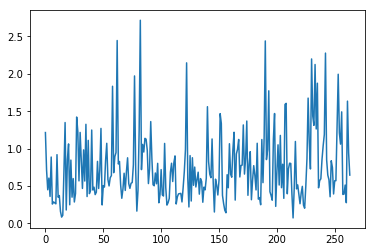

In [20]:
plt.plot(diff_dist)

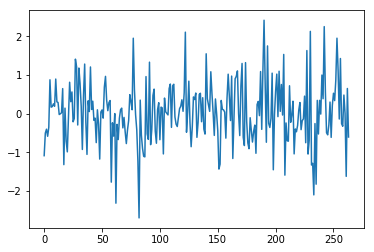

In [21]:
plt.plot(diff_y)

In [73]:
all_diff_norm = np.load('all_diff_norm.npy')
all_diff_x = np.load('all_diff_x.npy')
all_diff_y = np.load('all_diff_y.npy')

In [74]:
real_answ.head()

,file_name,bridge,city_entry,city_exit,road_bump,screen_wipers,zebra
0,akn.022.008.left.avi,0,0,0,1,0,0
1,akn.031.029.left.avi,0,0,0,1,0,1
2,akn.031.037.left.avi,0,0,0,1,1,1
3,akn.078.031.left.avi,0,0,1,0,0,0
4,akn.082.013.left.avi,0,0,1,0,0,0


In [75]:
#best rand_seed = 77612067520192
def train_cat_boost(graphs_chan_1, graphs_chan_2, graphs_chan_3, class_name = 'bridge'):
    model = catboost.CatBoostClassifier(random_seed=77612067520192)
    for_xgb_train = []
    for i in range(len(graphs_chan_1)):
        for_xgb_train.append(np.hstack((get_stats_for_file(graphs_chan_1[i]), get_stats_for_file(graphs_chan_3[i]))))
    for_xgb_train = np.array(for_xgb_train)
    data = pd.DataFrame(for_xgb_train)
    data["res"] = real_answ[class_name]
    a = cross_val_score(model, data.drop("res", axis=1), data["res"].values, cv = 2, scoring='roc_auc')
    print( a.mean(), a.std())
    model.fit(data.drop(["res"] , axis=1) , data["res"].values)
    return model

In [76]:
model = train_cat_boost(all_diff_norm, all_diff_x, all_diff_y, class_name = 'road_bump')

0.865824503906 0.0294457663644


In [12]:
model.save_model("model_road_bump")

--------

In [3]:
path = 'validationset/'
files = [video for video in os.listdir(path) if ".avi" in video and "._" not in video]

In [4]:
%%time
all_diff_norm = []
all_diff_x = []
all_diff_y = []
for file in tqdm_notebook(files):
    input_container = av.open(path + file)
    input_packets = input_container.demux()
    point_file = file[:-8]+'txt'
    y,x = open(path+point_file, 'r').readline().split(' ')
    x,y = int(x), int(y)
    diff_dist = []
    diff_x = []
    diff_y = []
    num = 0
    for packet in input_packets:
        frames = packet.decode()
        for raw_frame in frames:
            num+=1
            if (num<10):
                continue
            frame = raw_frame.to_rgb().to_nd_array()
            frame =  cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = frame[x - 100 : x + 200 , y - 100 : y + 100]
        
            if (num % 10) == 0:
                # params for ShiTomasi corner detection
                feature_params = dict( maxCorners = 100,
                                    qualityLevel = 0.3,
                                    minDistance = 7,
                                    blockSize = 7 )

                # Parameters for lucas kanade optical flow
                lk_params = dict( winSize  = (10,10),
                               maxLevel = 2,
                               criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

                # Create some random colors
                color = np.random.randint(0,255,(100,3))
                # Take first frame and find corners in it
                old_frame = frame
                old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
                p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

                # Create a mask image for drawing purposes
                mask = np.zeros_like(old_frame)

            else:
                try:
                    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    # calculate optical flow
                    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
                    # Select good points
                    good_new = p1[st==1]
                    good_old = p0[st==1]

                    diff_dist.append(np.mean(np.linalg.norm(good_new-good_old, axis = 1)))
                    diff_x.append(np.mean(good_new[:, 0] - good_old[:, 0]))
                    diff_y.append(np.mean(good_new[:, 1] - good_old[:, 1]))

                    # draw the tracks
                    for i,(new,old) in enumerate(zip(good_new,good_old)):
                        a,b = new.ravel()
                        c,d = old.ravel()
                        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
                        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
                    img = cv2.add(frame,mask)
                    #print_image(img)
                    # Now update the previous frame and previous points
                    old_gray = frame_gray.copy()
                    p0 = good_new.reshape(-1,1,2)
                except Exception:
                        print("Some error")
                        pass
    all_diff_norm.append(diff_dist)
    all_diff_x.append(diff_x)
    all_diff_y.append(diff_y)
    print ("File:", file)
np.save("all_diff_norm_val",all_diff_norm)
np.save("all_diff_x_val",all_diff_x)
np.save("all_diff_y_val",all_diff_y)
    #cv2.destroyAllWindows()

Widget Javascript not detected.  It may not be installed or enabled properly.


File: akn.031.008.left.avi


/anaconda/envs/open_cv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/envs/open_cv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
File: akn.031.041.left.avi
File: akn.048.067.left.avi
File: akn.078.047.left.avi
File: akn.079.064.left.avi
File: akn.081.021.left.avi
File: akn.081.054.left.avi
File: akn.082.001.left.avi
File: akn.084.020.left.avi
File: akn.090.121.left.avi
File: akn.112.004.left.avi
File: akn.113.142.left.avi
File: akn.131.019.left.avi
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
Some error
File: akn.132.075.left.avi
File: akn.136.038.left.avi
File: akn.136.059.left.avi
File: akn.136.213.left.avi
File: akn.136.274.left.avi
File: akn.139.044.left.avi
Some error
Some error
File: akn.145.038.left.avi
File: akn.145.141.left.avi
File: akn.151.155.left.avi
File: akn.152.144.left.avi
File: akn.160.015.left.avi
File: akn.160.030.left.avi
Some error
Some error
Some error
Some error
Some error
Some error
Some error
File: akn.160.215.left.avi
File: akn.160.227

File: akn.421.450.left.avi
File: akn.425.139.left.avi
File: akn.430.048.left.avi

CPU times: user 18min 18s, sys: 4min 13s, total: 22min 32s
Wall time: 15min 53s


In [12]:
all_diff_norm = np.load('all_diff_norm_val.npy')
all_diff_x = np.load('all_diff_x_val.npy')
all_diff_y = np.load('all_diff_y_val.npy')

In [13]:
model = catboost.CatBoostClassifier().load_model("model_road_bump")

In [14]:
def get_binary(class_name):
    if (class_name == 'bridge'):
        return '100000'
    elif (class_name == 'city_entry'):
        return '010000'
    elif (class_name == 'city_exit'):
        return '001000'
    elif (class_name == 'road_bump'):
        return '000100'
    elif (class_name == 'screen_wipers'):
        return '000010'
    elif (class_name == 'zebra'):
        return '000001'
    else:
        print("Error")

In [23]:
#92
def test_model(graphs_chan_1, graphs_chan_2, graphs_chan_3, class_name = 'road_bump', model=model):
    binary_class = get_binary(class_name)
    for_xgb_test = []
    for i in range(len(all_diff_norm)):
        for_xgb_test.append(np.hstack((get_stats_for_file(graphs_chan_1[i]), get_stats_for_file(graphs_chan_3[i]))))
    sub = pd.DataFrame(files)
    sub.columns = ["file_name"]
    sub['road_bump'] = model.predict_proba(for_xgb_test)[:,1]

    for i in sub.values:
        if (i[1]>=0.82):
            sub.loc[sub.file_name == i[0], "road_bump"] = '000100'
        else:
            sub.loc[sub.file_name == i[0], "road_bump"] = '000000'

    sub.to_csv('4.txt' , sep = ' ' , header=None , index=None)
    print (sub[sub['road_bump'] == binary_class].shape[0])

In [24]:
sub = test_model(all_diff_norm_val, all_diff_x_val, all_diff_y_val)

19
